10. Реализуйте вычислительную процедуру, позволяющую равномерно расположить N точек на поверхности сферической Земли. Воспользовавшись этой процедурой, разделите поверхность Земли на 64000 примерно одинаковых областей (сот). Назначьте всем сотам номера от 1 до 1008 так, чтобы максимизировать минимальное расстояние между центрами сот с одинаковыми номерами.

## Часть 1. Расстановка точек на сфере
Пытаемся найти на сфере точки $\{x_i\}_{i=1}^n$:
$$\min_{i\neq j}|x_i - x_j| -> \max $$

Описание алгоритма.

Задача решается методом деления пополам. Подбирается такое максимальное $d$, что можно расположить $N$ точек на сфере так, что все попарные расстояния не меньше чем $d$. 

При фиксированном $d$ алгоритм размещения точек следующий. Берем начальную точку $(1,0,0)$, строим вторую точку на расстоянии $d$ от нее. Далее, если уже размещено $k$ точек, то для каждой пары точек из них находим пару точек равноудаленных от них на расстоянии $d$. Из всех таких точек выбираем ту, которая ближе всех к начальной точке и находится на расстоянии не менее $d$ от уже размещенных. Эту точку размещаем на сфере и продолжаем пробовать добавить еще пока это возможно.

Далее считается, что сфера едничного радиуса.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import queue
import time

In [19]:
# Функция по двум точкам на сфере a и b находит пару точек на сфере
# равноудаленных от этих двух точек и находящихся на расстоянии d
def GetPointsOnDistanceD(a, b, d):
    vec_e = (a + b) / np.linalg.norm(a + b)
    h = (2 - d * d) / vec_e.dot(b) / 2
    if h * h > 1.0:
        return None, None
    xh = (1 - h * h)**0.5
    vec_p = np.cross(a, b)
    vec_p /= np.linalg.norm(vec_p)
    return (vec_e * h + vec_p * xh, vec_e * h - vec_p * xh)

Проверим предыдущую функцию на правильном тетраэдре. Для него радиус описанной окужности и длина ребра связаны соотношением:
$$R = \frac{\sqrt{6}}{4}a$$
Первая вершину зададим вектором (1,0,0), вторую - вектором $(\cos\alpha,\sin\alpha,0) $. Зная длину ребра, получаем: $\cos\alpha = -\frac{1}{3}$. По этим 2 вершинам находим оставшиеся 2 и проверяем попарные расстояния.

In [3]:
def CheckVectorLength(v, d, eps=1e-10):
    assert abs(np.linalg.norm(v) - d) < eps, f'Длина вектора равна {np.linalg.norm(v)}, ожидали {d}'
    
def GetStartPoints(d):
    x = 1.0 - d * d / 2
    y = (1.0 - x * x) ** 0.5
    return np.array([1.0, 0.0, 0.0]), np.array([x, y, 0.0])

def CheckGetPointsOnDistanceD():
    d = 4.0 / 6.0**0.5
    a, b = np.array([1.0, 0.0, 0.0]), np.array([-1.0 / 3.0, 8.0**0.5 / 3.0, 0])
    v1, v2 = GetPointsOnDistanceD(a, b, d)
    points = [a, b, v1, v2]
    # Проверим, что длины векторов 1
    for p in points:
        CheckVectorLength(p, 1.0)
    # Проверим, что попарные расстояния между точками равны 4/sqrt(6)
    for i in range(4):
        for j in range(i+1, 4):
            CheckVectorLength(points[i] - points[j], d)
    print('Функция GetPointsOnDistanceD успешно проверена на правильном тетраэдре!')
    
CheckGetPointsOnDistanceD()

Функция GetPointsOnDistanceD успешно проверена на правильном тетраэдре!


In [15]:
# Основная функция, пытается разместить n точек на сфере чтобы попарные расстояния были не меньше d
def PlacePointsOnSphereFixedLength(n, d):
    count = 1
    result = np.zeros((n, 3))
    main_point, first = GetStartPoints(d)
    # В очереди хранятся все точки кандидаты на добавление
    work = queue.PriorityQueue()    
    result[0,:] = main_point
    
    def AddPoint(point):
        if point is not None:
            dist = (point[0] - 1)**2 + point[1]**2 + point[2]**2
            work.put((dist, point[0], point[1], point[2]))

    AddPoint(first)            
    eps = 1e-10
    d2_min = d**2 - eps
    d2_max = 4 * d**2 - eps
    
    while count < n and not work.empty():
        point = np.array(work.get()[1:])
        all_distances = np.sum((result[:count,:] - point[None,:])**2, axis=1)
        # Проверяем, что расстояния до всех точек не меньше d
        if not np.all(all_distances > d2_min):
            continue            
        result[count,:] = point
        count += 1
        # Для каждой уже добавленной точки, расстояние до которой меньше 2d добавляем в очередь
        # пару точек находящихся на расстоянии d от этой точки и новой
        for index in np.where(all_distances < d2_max)[0]:
            p1, p2 = GetPointsOnDistanceD(result[index,:], point, d)
            AddPoint(p1)
            AddPoint(p2)
        
    return result[:count,:]

# Функция методом деления пополам пробует подобрать такое d, что можно разместить n точек 
# для которых все попарные расстояния не меньше d
def PlacePointsOnSphere(n, eps = 1e-6, verbose=True):
    if verbose:
        print(f'Start search points on sphere, n = {n}')
    d1, d2 = 1e-3, 1.9
    time_start = time.time()
    last_result = None
    while d2 - d1 > eps:
        d = (d1 + d2) / 2
        t1 = time.time()
        result = PlacePointsOnSphereFixedLength(n, d)
        if result.shape[0] < n:
            d2 = d
        else:
            last_result = result
            d1 = d
        t2 = time.time()
        if verbose:
            print(f'\td = {d:8.6f}, time = {t2 - t1:7.2f}, points = {result.shape[0]:5}')
            
    if verbose:
        seconds = int(time.time() - time_start)
        print(f'Total time: {seconds // 60}:{seconds % 60:02} sec.')

    return last_result

# Проверить размещение точек, что все лежат на сфере.
# Возвращает min и max по всем точкам расстояния до ближайшего соседа
def CheckPointsOnSphere(points):
    eps = 1e-10
    assert np.max(np.abs(np.sum(points**2, axis=1) - 1)) < eps, 'Lengt.hs of vectors not equal 1.0!'
    n = points.shape[0]
    d_min, d_max = 1e6, 0.0
    for i in range(1, n):
        d_cur = np.min(np.sum((points[i,:] - points[:i,:])**2, axis=1))
        d_min = min(d_cur, d_min)
        d_max = max(d_cur, d_max)
    d_min, d_max = d_min**0.5, d_max**0.5
    return d_min, d_max, f'[{d_min:12.10f}, {d_max:12.10f}] {d_max - d_min:12.10f}'

def SaveResults(points, filename):
    f = open(filename, 'w')
    for i in range(points.shape[0]):
        f.write(f'{points[i][0]} {points[i][1]} {points[i][2]}\n')
    f.close()

Проверим на правильном икосаэдре. У него 12 вершин. Длина ребра равна:
$$ \frac{4}{\sqrt{2(5 + \sqrt{5})}}$$

In [23]:
points12 = PlacePointsOnSphere(12, verbose=False, eps=1e-10)
print(f'Вычисленное значение:   {CheckPointsOnSphere(points12)[0]}')
real_edge = 4 / (2 * (5 + 5 ** 0.5)) ** 0.5
print(f'Теоретическое значение: {real_edge}')

Вычисленное значение:   1.0514622242134937
Теоретическое значение: 1.0514622242382672


800 вершин:

In [5]:
points800 = PlacePointsOnSphere(800)

Start search points on sphere, n = 800
	d = 1.000500, time =    0.01, points =    12
	d = 0.500750, time =    0.03, points =    50
	d = 0.250875, time =    0.13, points =   207
	d = 0.125937, time =    0.59, points =   800
	d = 0.188406, time =    0.25, points =   367
	d = 0.157172, time =    0.37, points =   529
	d = 0.141555, time =    0.47, points =   654
	d = 0.133746, time =    0.54, points =   732
	d = 0.129842, time =    0.58, points =   778
	d = 0.127890, time =    0.60, points =   800
	d = 0.128866, time =    0.59, points =   788
	d = 0.128378, time =    0.59, points =   794
	d = 0.128134, time =    0.59, points =   797
	d = 0.128012, time =    0.60, points =   798
	d = 0.127951, time =    0.60, points =   799
	d = 0.127920, time =    0.59, points =   799
	d = 0.127905, time =    0.60, points =   800
	d = 0.127913, time =    0.59, points =   799
	d = 0.127909, time =    0.59, points =   799
	d = 0.127907, time =    0.60, points =   800
	d = 0.127908, time =    0.60, points =  

In [6]:
CheckPointsOnSphere(points800)[-1]

'[0.1279077592, 0.1279077592] 0.0000000000'

In [7]:
SaveResults(points800, '800.txt')

64000 точек:

In [10]:
points64000 = PlacePointsOnSphere(64000)

Start search points on sphere, n = 64000
	d = 1.000500, time =    0.01, points =    12
	d = 0.500750, time =    0.04, points =    50
	d = 0.250875, time =    0.14, points =   207
	d = 0.125937, time =    0.62, points =   826
	d = 0.063469, time =    3.56, points =  3265
	d = 0.032234, time =   30.15, points = 12674
	d = 0.016617, time =  353.80, points = 48029
	d = 0.008809, time =  692.70, points = 64000
	d = 0.012713, time =  667.79, points = 64000
	d = 0.014665, time =  585.07, points = 61555
	d = 0.013689, time =  645.78, points = 64000
	d = 0.014177, time =  634.95, points = 64000
	d = 0.014421, time =  623.60, points = 63844
	d = 0.014299, time =  628.24, points = 64000
	d = 0.014360, time =  627.11, points = 64000
	d = 0.014391, time =  628.18, points = 64000
	d = 0.014406, time =  625.68, points = 64000
	d = 0.014413, time =  626.18, points = 63915
	d = 0.014410, time =  639.06, points = 64000
	d = 0.014411, time =  636.19, points = 64000
	d = 0.014412, time =  634.58, points =

In [11]:
SaveResults(points64000, '64000.txt')

In [24]:
CheckPointsOnSphere(points64000)[2]

'[0.0144124403, 0.0144124417] 0.0000000014'

При радиусе Земли 6371 км расстояние между точками будет примерно 92 км.

Попробуем сделаеть оценку на расстояние. Для этого приближенно будем считать, что удалось покрыть всю поверхность равными правильными треугольниками и в каждой точке сходится 6 таких треугольников (такое невозможно конечно). При фиксированном $d$ найдем площадь одного сферического треугольника, она равна:
$$ S = \alpha + \beta + \gamma - \pi$$
Количество треугольников приближенно будет равно:
$$ \frac{4\pi}{S}$$
Количество вершин будет в 2 раза меньше. Далее, методом деления пополам подбираем $d$ чтобы получилось нужное количество точек.

In [25]:
def GetThereoticalD(n):
    def GetNormTo(a, b):
        r = b - a.dot(b) / a.dot(a) * a
        return r / np.linalg.norm(r)

    def GetVertexCountByD(d):
        a, b = GetStartPoints(d)
        c = GetPointsOnDistanceD(a, b, d)[0]
        nab, nac = GetNormTo(c, a), GetNormTo(c, b)
        st = 3 * np.arccos(nab.dot(nac)) - np.pi
        ss = 4 * np.pi
        return ss / st / 2
    
    d1, d2 = 1e-6, 1.0
    eps = 1e-6
    while d2 - d1 > eps:
        d = (d1 + d2) / 2
        if GetVertexCountByD(d) > n:
            d1 = d
        else:
            d2 = d
    return (d1 + d2) / 2
    
GetThereoticalD(64000)

0.015057118214130402

Это значение примерно на 4.5% больше.

Визуализируем расположение точек на сфере в окрестностях некоторых фиксированных точек.

In [26]:
def PlotPointsProjection(ax, points, main_vector, delta=0.9, color='b', marker='o'):
    selected = points[np.sum(points * main_vector[None,:], axis=1) > delta]
    e1 = np.cross(main_vector, np.random.normal(size=3))
    e1 = e1 / np.linalg.norm(e1)
    e2 = np.cross(main_vector, e1)
    e2 = e2 / np.linalg.norm(e2)
    
    xs = np.sum(selected * e1[None,:], axis=1)
    ys = np.sum(selected * e2[None,:], axis=1)
    
    ax.scatter(xs, ys, c=color, marker=marker)
    if str(type(plt)) == "<class 'module'>":
        plt.title(f'{main_vector}')
    else:
        ax.set_title(f'{main_vector}')
    
def PlotPointsForProjection(points, delta=0.9):
    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    PlotPointsProjection(axs[0,0], points, np.array([ 1,  0, 0]), delta=delta)
    PlotPointsProjection(axs[0,1], points, np.array([-1,  0, 0]), delta=delta)
    PlotPointsProjection(axs[1,0], points, np.array([ 0,  0, 1]), delta=delta)
    PlotPointsProjection(axs[1,1], points, np.array([ 0, -1, 0]), delta=delta)

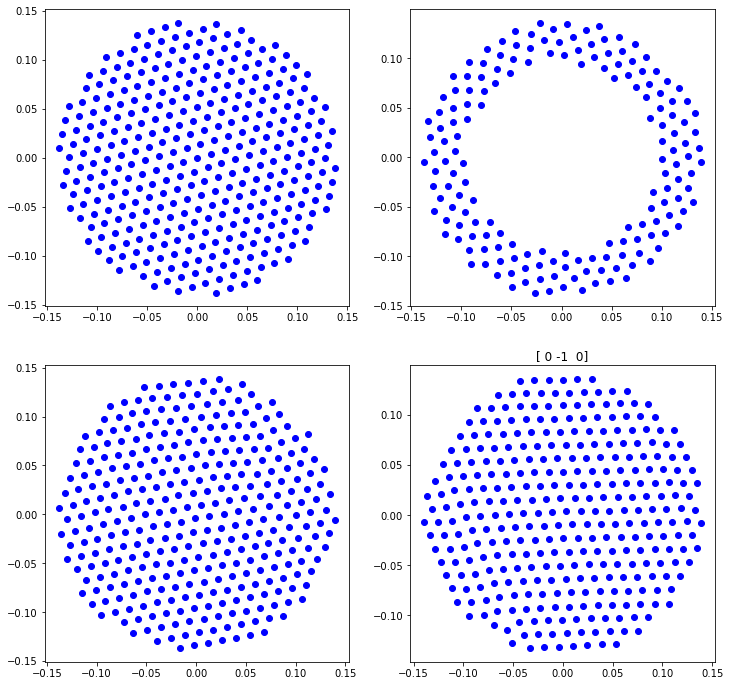

In [27]:
PlotPointsForProjection(points64000, delta=0.99)

### Итоги:
- Результаты на правильном икосаэдре и сравнение с теоретической оценкой на большом $N$ дают основания полагать, что алгоритм работает относительно правильно.
- Время работы на одно итерации около 10 минут. Можно значительно ускорить, в том числе если использовать быстрый поиск точек в окрестности использую KdTree.
- Есть эффект "озоновой" дыры в районе точки противоположной начальной.

### Другие идеи
Первоначально рассматривал идею следующего алгоритма:
- Генерируем выборку $kN$ точек из равномерного распределения на сфере ($k$ некий параметр). Если не ошибаюсь, это распределение можно получить следующим образом. Генерируем $x,y,z \sim N(0,1)$, далее нормируем 3 координаты чтобы попасть на сферу.
- Запускаем процедуру объединения ближко лежащих друг к другу точек пока не останется $N$ точек.
- Далее представляем эти точки как систему механических точек с отталкивающими силами и запускаем расчет их движения. Тут надо подобрать удачный закон взаимодействия точек.

## Часть 2. Раскраска точек

In [2]:
def LoadResults(filename):
    f = open(filename)
    lines = f.readlines()
    n = len(lines)
    result = np.zeros((n,3))
    for i in range(n):
        result[i] = np.array(list(map(float, lines[i].strip().split())))
    f.close()
    return result

def SortByLengthFromFirst(data):
    n = data.shape[0]
    result = np.zeros((n,4))
    result[:,1:] = data
    result[:,0] = np.sum((data - data[0,:])**2, axis=1)
    return np.array(sorted([list(r) for r in result]))[:,1:]

Загрузим расставленные в первой части точки на сфере

In [3]:
points, k = SortByLengthFromFirst(LoadResults('64000.txt')), 1008
n = points.shape[0]

Для каждой точки найдем k-ую по удаленности точку. Найдем минимум по всем расстояниям до k-ой точки.

In [5]:
def GetMinDist(points, k, batch_size=500, verbose=True):
    t_start = time.time()
    n = points.shape[0]
    p1 = 0
    min_dist = 100.0
    while p1 < n:
        p2 = p1 + batch_size
        dists = np.sum((points[p1:p2,None,:] - points[None,:,:])**2, axis=2)
        quants = np.quantile(dists, (k + 1) / n, axis=1)
        cur = np.min(quants)
        min_dist = min(min_dist, cur)
        if verbose:
            print(f'\r{p1:5d} {cur:8.6f} {min_dist:8.6f}', end='')
        p1 = p2
    if verbose:
        print('\r', ' ' * 60, end='\r')
        print(f'Время поиска минимального расстояния: {time.time() - t_start}')
    return min_dist

min_dist = GetMinDist(points, k)

Время поиска минимального расстояния: 260.84517908096313     


In [14]:
print(f'Оценка сверху на расстояние: {min_dist**0.5}')

Оценка сверху на расстояние: 0.2402349293459649


Лучше чем это значение мы не найдем

Построим граф с ребрами, длины которых меньше этого значения

In [7]:
class Graph:
    def __init__(self, size):
        self.size = size
        self.edges = [dict() for _ in range(size)]
    
    def AddEdge(self, u, v, dist):
        self.edges[u][v] = dist
        self.edges[v][u] = dist
        
def BuildGraph(points, min_dist, batch_size=500, verbose=True):
    t_start = time.time()
    n = points.shape[0]
    graph = Graph(n)
    p1 = 0
    while p1 < n:
        p2 = p1 + batch_size
        dists = np.sum((points[p1:p2,None,:] - points[None,:,:])**2, axis=2)
        for i in range(p1, p2):
            candidates = np.where(dists[i - p1] < min_dist)
            for j in candidates[0]:
                if i != j:
                    graph.AddEdge(i, j, dists[i - p1][j] ** 0.5)
        if verbose:
            print(f'\r{p1:5d}', end='')
        p1 = p2
        #break
    
    if verbose:
        print('\r', ' ' * 60, end='\r')
        print(f'Время построения графа: {time.time() - t_start}')
    return graph
        
graph = BuildGraph(points, min_dist)

Время построения графа: 240.51024651527405                   


Жадный алгоритм. Начинаем со стартовой точки, далее берем точки в порядке удаленности от стартовой точки. Для первых k точек ставим неиспользованный еще цвет. Для остальных выбираем такой цвет, чтобы расстояние до точек этого цвета было максимальным.

Планировал использовать это как начальное состояние для метода отжига, но оказалось, что оно дает оптимальное решение.

In [8]:
def BuildGreedyColors(graph, color_count, verbose=True):
    t_start = time.time()
    colors = np.zeros(graph.size, dtype=np.int32)
    for i in range(color_count):
        colors[i] = i
    for i in range(color_count, graph.size):
        if verbose and i % 1000 == 0:
            print(f'\r{i:5d}', end='')
            
        candidates = np.ones(color_count, dtype=np.float32) * 100
        for j, d in graph.edges[i].items():
            if j < i:
                candidates[colors[j]] = min(candidates[colors[j]], d)
        cur_color = np.argmax(candidates)
        colors[i] = cur_color
        
    if verbose:
        print('\r', ' ' * 60, end='\r')
        print(f'Время построения жадного решения: {time.time() - t_start}')
    return colors

colors = BuildGreedyColors(graph, k)

Время построения жадного решения: 26.803895711898804         


In [9]:
def SaveToFileWithColors(points, colors, filename):
    f = open(filename, 'w')
    for i in range(len(colors)):
        f.write(f'{points[i][0]} {points[i][1]} {points[i][2]} {colors[i] + 1}\n')
    f.close()
    
SaveToFileWithColors(points, colors, '64000_1008.txt')

Выполним различные проверки для полученного решения

In [12]:
def CheckResultsFromFile(filename):
    f = open(filename)
    lines = f.readlines()
    n = len(lines)
    print(f'Файл:   {filename}\nТочек:  {n}')
    
    points = np.zeros((n,3), dtype=np.float32)
    colors = np.zeros(n, dtype=np.int32)
    for i in range(n):
        points[i,:] = np.array(list(map(float, lines[i].split()[:3])))
        colors[i] = int(lines[i].strip().split()[-1]) - 1
    k = np.max(colors) + 1
    print(f'Цветов: {k}')
    
    # Найдем отклонения от сферы
    diff_sphere = np.max(np.abs(np.sum(points**2, axis=1) - 1))
    print(f'\nОтклонение от сферы максимальное: {diff_sphere}')
    
    # Найдем минимальное расстояние между парами точек
    p1 = 0
    batch_size = 1000
    min_points_dist = 1000
    while p1 < n:
        print(f'\r{p1:5d}', end='')
        p2 = p1 + batch_size
        dists = np.sum((points[p1:p2,None,:] - points[None,:,:])**2, axis=2)
        dists[:,p1:p1 + dists.shape[0]] += np.eye(dists.shape[0])
        min_points_dist = min(min_points_dist, dists.min())
        p1 = p2
    min_points_dist = min_points_dist**0.5
    print(f'\rМинимальное расстояние между 2 точками: {min_points_dist}')
    
    # Найдем минимальное расстояние между точками одного цвета
    points_by_colors = [[] for _ in range(k)]
    for i in range(n):
        points_by_colors[colors[i]].append(points[i])
    min_dist_color = 100.0
    for color in range(k):
        p = np.array(points_by_colors[color])
        dists = np.sum((p[:,None,:] - p[None,:,:])**2, axis=2) + np.eye(p.shape[0])
        min_dist_color = min(min_dist_color, dists.min())
    min_dist_color = min_dist_color ** 0.5
    print(f'Минимальное расстояние между точками одного цвета: {min_dist_color}')

CheckResultsFromFile('64000_1008.txt')

Файл:   64000_1008.txt
Точек:  64000
Цветов: 1008

Отклонение от сферы максимальное: 1.1920928955078125e-07
Минимальное расстояние между 2 точками: 0.014412368517219679
Минимальное расстояние между точками одного цвета: 0.2402349410011633
